**1.a) Code Explanation**

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Define constants
N = 100
ORDER = 2
N_FOLDS = 20
POLY_DEGREE = np.arange(1, 11)
N_REPLICATES = 10

# Set random seed for reproducibility
np.random.seed(123)

# Generate simulated data
x = np.random.uniform(low=-4, high=4, size=N)
y = np.random.normal(loc=x**ORDER, scale=0.25, size=N)
data = pd.DataFrame({'x': x, 'y': y})

# Run multiple replicates and average the MSE estimates
mse_estimates = np.zeros((N_REPLICATES, len(POLY_DEGREE)))
for r in range(N_REPLICATES):
  kf = KFold(n_splits=N_FOLDS, shuffle=True)
  indices = [(train_index, test_index) for train_index, test_index in kf.split(data)]
  for q_idx, q in enumerate(POLY_DEGREE):
    y_hat = np.zeros(N)
    for train_index, test_index in indices:
      # Fit on K-1 folds
      x_train, y_train = data.iloc[train_index]['x'].to_numpy(), data.iloc[train_index]['y'].to_numpy()  # Convert to numpy arrays for reshape
      poly = PolynomialFeatures(degree=q)
      x_train_poly = poly.fit_transform(x_train.reshape(-1, 1))
      lin_reg = LinearRegression()
      lin_reg.fit(x_train_poly, y_train)

      # Predict on the kth fold
      x_test = data.iloc[test_index]['x'].to_numpy()  # Convert to numpy array for reshape
      x_test_poly = poly.fit_transform(x_test.reshape(-1, 1))
      y_hat[test_index] = lin_reg.predict(x_test_poly)

      # Get the MSE estimate
      mse_estimate = np.mean((y_hat - data['y'])**2)
      mse_estimates[r, q_idx] = mse_estimate

# Average the MSE estimates across replicates
mse_mean = np.mean(mse_estimates, axis=0)
mse_std = np.std(mse_estimates, axis=0)


In [4]:
print(mse_mean)
print(mse_std)

[18.90941334  0.06392184  0.06529567  0.06645944  0.06635131  0.06711744
  0.06887067  0.06992106  0.07416099  0.08925889]
[0.2704315  0.00074919 0.0010154  0.00124199 0.00088693 0.00130226
 0.00204394 0.00160397 0.00287653 0.00666339]


* The above code is generating two variable x and y. x as a random uniform variable and y is generated with some noise using the polynomial relation defined by the ORDER 2.
* After generating the variables, the code runs k-fold cross validation 20 times(N_FOLDS) and assess model performance.
* Within the k-fold cross-validation, the script fits polynomial regression models, predicts on the test fold, and calculates the Mean Squared Error(MSE) estimate each time.
* The mean and standard deviation of the MSE estimate is then calculated.



**1.b) Improved the reproducibility and clarity of the resampling code from part (a), corrected any errors, and generated two plots: (1) mean squared error versus polynomial order to identify the best-fitting model, and (2) `x` versus `y` overlaid with the selected polynomial regression line.**


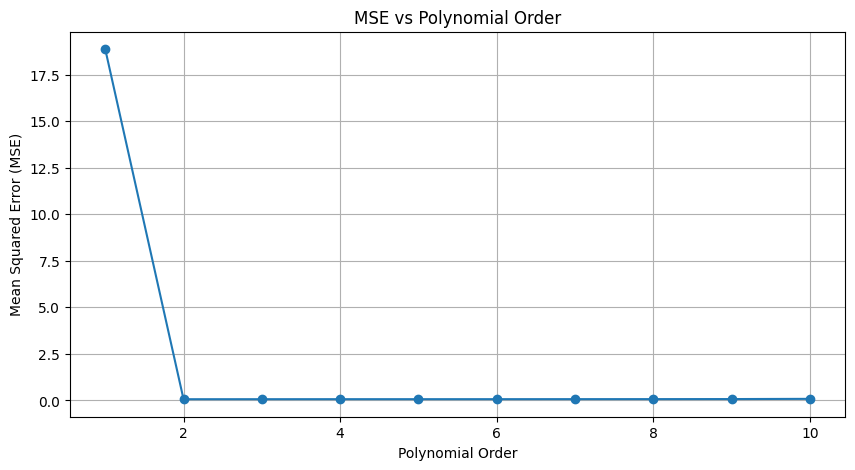

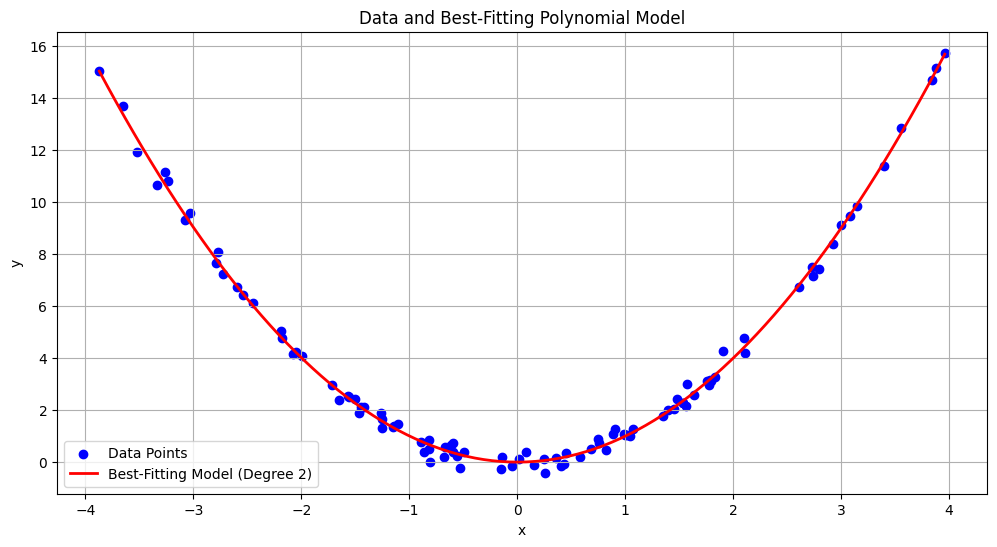

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

N = 100
order = 2
poly = np.arange(1, 11)

np.random.seed(123)

x = np.random.uniform(low=-4, high=4, size=N)
y = np.random.normal(loc=x**order, scale=0.25, size=N)
data = pd.DataFrame({'x': x, 'y': y})

mse_values = []
models = []

kf = KFold(n_splits=N, shuffle=True)

for q in poly:
    mse_values_fold = []
    model_fold = []

    for train_index, test_index in kf.split(data):
        x_train, y_train = data.iloc[train_index]['x'], data.iloc[train_index]['y']
        x_test, y_test = data.iloc[test_index]['x'], data.iloc[test_index]['y']

        p = PolynomialFeatures(degree=q)
        x_train_poly = p.fit_transform(x_train.values.reshape(-1, 1))

        lin = LinearRegression().fit(x_train_poly, y_train)

        x_test_poly = p.transform(x_test.values.reshape(-1, 1))
        y_hat = lin.predict(x_test_poly)

        mse = np.mean((y_hat - y_test)**2)
        mse_values_fold.append(mse)
        model_fold.append(lin)

    mse_values.append(np.mean(mse_values_fold))
    models.append(model_fold[0])

best_degree = poly[np.argmin(mse_values)]
best_model = models[np.argmin(mse_values)]

plt.figure(figsize=(10, 5))
plt.plot(poly, mse_values, marker='o')
plt.title('MSE vs Polynomial Order')
plt.xlabel('Polynomial Order')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid()
plt.show()

x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)
x_range_poly = PolynomialFeatures(degree=best_degree).fit_transform(x_range)
y_pred = best_model.predict(x_range_poly)

plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Data Points', c='b')
plt.plot(x_range, y_pred, label=f'Best-Fitting Model (Degree {best_degree})', c='r', linewidth=2)
plt.title('Data and Best-Fitting Polynomial Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

**Q2: Applied bootstrap sampling (`n = 1000`) to estimate the median and 95% confidence intervals for the slope and intercept of the regression between `x` and `y_measured`, and compared how the median parameter estimates change when using `y` instead of `y_measured`.**

In [6]:
import numpy as np
from numpy.random import default_rng
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from scipy.stats import scoreatpercentile

rng = default_rng(seed=1)
nobs = 1000
x = rng.normal(size=nobs)
y = x - 2 * x**2
y_measured = y + rng.normal(size=nobs)

# BEGIN SOLUTION

nobs = 1000
n_bootstrap = 1000

slope_measured = np.zeros(n_bootstrap)
intercept_measured = np.zeros(n_bootstrap)
slope_y = np.zeros(n_bootstrap)
intercept_y = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    y_measured_bootstrap = resample(y_measured, replace=True, n_samples=nobs)

    model_measured = LinearRegression()
    model_measured.fit(x[:, np.newaxis], y_measured_bootstrap)
    slope_measured[i] = model_measured.coef_[0]
    intercept_measured[i] = model_measured.intercept_

    model_y = LinearRegression()
    model_y.fit(x[:, np.newaxis], y)
    slope_y[i] = model_y.coef_[0]
    intercept_y[i] = model_y.intercept_

median_slope_measured = np.median(slope_measured)
median_intercept_measured = np.median(intercept_measured)
ci_slope_measured = (scoreatpercentile(slope_measured, 2.5), scoreatpercentile(slope_measured, 97.5))
ci_intercept_measured = (scoreatpercentile(intercept_measured, 2.5), scoreatpercentile(intercept_measured, 97.5))

median_slope_y = np.median(slope_y)
median_intercept_y = np.median(intercept_y)
ci_slope_y = (scoreatpercentile(slope_y, 2.5), scoreatpercentile(slope_y, 97.5))
ci_intercept_y = (scoreatpercentile(intercept_y, 2.5), scoreatpercentile(intercept_y, 97.5))

print("For y_measured:")
print("Median Slope:", median_slope_measured)
print("95% CI for Slope:", ci_slope_measured)
print("Median Intercept:", median_intercept_measured)
print("95% CI for Intercept:", ci_intercept_measured)

print("\nFor y:")
print("Median Slope:", median_slope_y)
print("95% CI for Slope:", ci_slope_y)
print("Median Intercept:", median_intercept_y)
print("95% CI for Intercept:", ci_intercept_y)
# END SOLUTION

For y_measured:
Median Slope: 0.0023651487756162944
95% CI for Slope: (-0.18848216965679718, 0.2175214222459419)
Median Intercept: -1.970044645955639
95% CI for Intercept: (-2.1809386529094255, -1.7713658919911754)

For y:
Median Slope: 1.2108031975918776
95% CI for Slope: (1.2108031975918776, 1.2108031975918776)
Median Intercept: -1.9398721355871174
95% CI for Intercept: (-1.9398721355871174, -1.9398721355871174)


* Since the median slope for y is much larger than median slope for y_measured, it indicates a stronger positive linear relationship between x and y compared to the relationship between x and y_measured.



**Q3) Loaded the College dataset to predict the number of applications received using the remaining predictor variables.**

**Importing Libraries:**

In [7]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

**Loading dataset:**

In [8]:
#READ AUTO.CSV DATASET
df = pd.read_csv("data.csv")
df.head()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend,grad_rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   private      777 non-null    object 
 1   apps         777 non-null    int64  
 2   accept       777 non-null    int64  
 3   enroll       777 non-null    int64  
 4   top10perc    777 non-null    int64  
 5   top25perc    777 non-null    int64  
 6   f_undergrad  777 non-null    int64  
 7   p_undergrad  777 non-null    int64  
 8   outstate     777 non-null    int64  
 9   room_board   777 non-null    int64  
 10  books        777 non-null    int64  
 11  personal     777 non-null    int64  
 12  phd          777 non-null    int64  
 13  terminal     777 non-null    int64  
 14  s_f_ratio    777 non-null    float64
 15  perc_alumni  777 non-null    int64  
 16  expend       777 non-null    int64  
 17  grad_rate    777 non-null    int64  
dtypes: float64(1), int64(16), object(1)
memory usage: 

In [10]:
df.private.value_counts()

Yes    565
No     212
Name: private, dtype: int64

In [11]:
df['private'] = df['private'].map({'Yes': 1, 'No': 0})
df.head()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend,grad_rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [12]:
df.describe()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend,grad_rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,0.727156,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,0.445708,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,0.000000,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,0.000000,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1.000000,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,1.000000,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,1.000000,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000


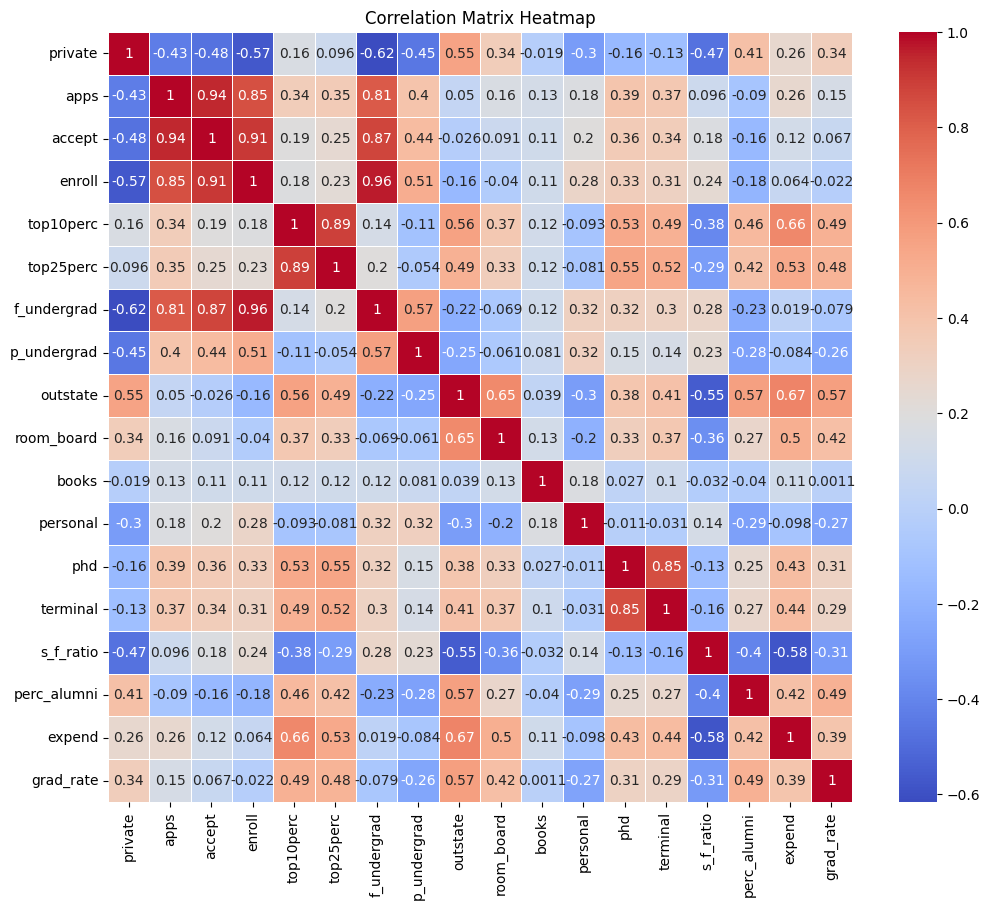

In [ ]:
correlation_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

**3.a) Splitting the data set into a training set and a test set.**

In [ ]:
X = df.drop('apps', axis=1)
y = df['apps']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Q3.b) Fitted a least squares linear regression model on the training set and reported the test error on the held-out data.**


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print("Test Mean Squared Error (MSE):", test_mse)
print("Test R-squared (R2):", test_r2)

Test Mean Squared Error (MSE): 1492443.3790390454
Test R-squared (R2): 0.8877583168400976


**Q3.c) Fitted a ridge regression model on the training set using cross-validation to select the optimal (\lambda), and reported the corresponding test error.**

In [ ]:
alphas = [0.1, 1.0, 10.0]
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
p = X_train.shape[1]
adj_r_squared = 1 - (1 - r_squared) * ((nobs - 1) / (nobs - p - 1))

print("Best 𝜆 (alpha) chosen by cross-validation:", best_alpha)
print("Test Error (MSE):", test_error)
print("R-squared:", r_squared)
print("Adjusted R-squared:", adj_r_squared)

Best 𝜆 (alpha) chosen by cross-validation: 10.0
Test Error (MSE): 1478572.8112797
R-squared: 0.8888014759264375
Adjusted R-squared: 0.8868764505606019


**Q3.d) Fitted a lasso regression model on the training set using cross-validation to select the optimal (\lambda), reported the test error, and noted the number of non-zero coefficients in the model.**

In [17]:
alphas = [0.1, 1.0, 10.0]
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

test_error = mean_squared_error(y_test, y_pred)

r_squared = r2_score(y_test, y_pred)

p = X_train.shape[1]

adj_r_squared = 1 - (1 - r_squared) * ((len(y_test) - 1) / (len(y_test) - p - 1))

non_zero_coefficients = np.sum(lasso_model.coef_ != 0)

print("Best 𝜆 (alpha) chosen by cross-validation:", best_alpha)
print("Test Error (MSE):", test_error)
print("R-squared:", r_squared)
print("Adjusted R-squared:", adj_r_squared)
print("Number of Non-Zero Coefficients:", non_zero_coefficients)

Best 𝜆 (alpha) chosen by cross-validation: 10.0
Test Error (MSE): 1477249.0026809825
R-squared: 0.8889010351508533
Adjusted R-squared: 0.8752149307853787
Number of Non-Zero Coefficients: 17
